# PROJECT LUTHER - HACKING THE SF RENTAL MARKET

__Project Goals:__ 

Determine key parameters/features of home rentals that dictates it's rental price in the city of San Francisco. Highlight key features to inform and provide guidelines to budget-constrained rentees.

__Project Approach:__

1. Scrape data from cragslist using Beautifulsoup4 
2. Perform linear regression analysis using StatsModels and scikit-learn libraries


__Project Notes:__

The following notebook analyzes data scraped from Craigslist. Craigslist (https://sfbay.craigslist.org/d/apts-housing-for-rent/search/apa) is a popular website for rentees as it contains a large selection of listings with lower prices compared to more modern and newer apartment complexes that are professionally managed or requires management fees. Most of the listings are put up by self managing landlords of tenants looking to sublet a room. Over 3000 listings were scraped between October 6 and 7, 2018. Of the 3000 listings scraped only 763 were unique. These 763 datapoints were used for this analysis. 

Note: 
Several different .ipynb files were used for this project: 

* **CL_Scrape_2.ipynb** was used to scrape Craiglist and append data to CSV file
* **ReverseGeoCoding.ipynb** was used to load in CSV file, convert and clean dataframe, and outputted csv file to be used for a reverse geocoding service to extract location data. After location data was retreived, this same notebook was used to load in the new csv with location data and merge with previous csv file.   
* Lastly, this notebook, **Project_Luter_SF_Rentals.ipynb**, was used for some final cleaning/modification of the dataframe and performing all statiscal analysis

In [1]:
# all of the imports
import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import feature_selection as f_select
from sklearn.linear_model import RidgeCV
% matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Data cleaning, Preprocessing, Feature Engineering

In [2]:
# load in dataframe
df = pd.read_csv('/Users/medfordxie/Desktop/DS/Project_Luther/csv files/cleaned_sf.csv')

**Check to see how many entries are in each features. For smaller amount of entries, the stats model may not account for lower frequency entries (unweighted). Need to do a separate anaylysis to adjust for it.** 

In [74]:
df.sum()

Unnamed: 0                                                         1305838
title                    1/2 Block From GG Park| Remodeled 3BR/2BA W/ P...
rental price                                                       2776144
bedrooms                                                              1065
bathrooms                                                            881.5
Area (SF)                                                           303854
latitude,longitude       (37.773854, -122.477838)(37.804917, -122.44213...
cats are OK - purrr                                                    379
dogs are OK - wooof                                                    345
w/d in unit                                                              0
wd in unit                                                             283
laundry in bldg                                                        264
laundry on site                                                         64
attached garage          

**Names of target and features**

Y = 'rental price'

X = 'title','bedrooms','bathrooms','Area (SF)','cats are OK - purrr', 
'dogs are OK - wooof','w/d in unit','wd in unit','laundry in bldg','laundry on site','attached garage','detached garage','carport','furnished','no smoking','wheelchair accessible', 'Zip'


The following sections will combine some of these features into one. (i.e. listings with both "cats are ok" and "dogs are ok" will be counted as "pets allowed")

---

combine "cats are ok" and "dogs are ok" as "pets allowed"  
NOTE: additional 34 listings allowed cats only, but not dogs. They will be excluded from "pets_allowed"

In [4]:
df['dogs are OK - wooof'].astype(int,inplace = True)
df['cats are OK - purrr'].astype(int,inplace = True)

0      0
1      1
2      1
3      0
4      0
5      0
6      0
7      1
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     1
22     0
23     0
24     1
25     0
26     1
27     1
28     0
29     0
      ..
733    0
734    1
735    1
736    0
737    0
738    0
739    1
740    0
741    1
742    1
743    1
744    1
745    0
746    1
747    0
748    0
749    0
750    0
751    0
752    0
753    0
754    1
755    0
756    1
757    0
758    0
759    0
760    0
761    1
762    0
Name: cats are OK - purrr, Length: 763, dtype: int64

In [5]:
def pets(row):
    if row['dogs are OK - wooof'] == 1 & row['cats are OK - purrr'] == 1:
        val = 1
    else:
        val = 0
    return val

In [6]:
df['pets_allowed'] = df.apply(pets, axis=1)

In [7]:
df.pets_allowed.value_counts()

0    432
1    331
Name: pets_allowed, dtype: int64

combine 'w/d in unit' and 'wd in unit' as 'laundry in unit'

In [8]:
df['laundry in unit'] = df['w/d in unit'] + df['wd in unit']
df['laundry in unit'].sum()

283

combine 'laundry in bldg' and 'laundry on site' as "laundry on premise"

In [9]:
df['laundry on premise'] = df['laundry in bldg'] + df['laundry on site']
df['laundry on premise'].sum()

328

combine 'attached garage' and 'detached garage','carport' as "parking available"

In [10]:
df['parking available'] = df['attached garage'] + df['detached garage'] + df['carport']
df['parking available'].sum()

289

In [11]:
df['pets_allowed'].fillna(0, inplace=True)
df['pets_allowed'] = df['pets_allowed'].astype(int)
df['pets_allowed']

0      0
1      1
2      1
3      0
4      0
5      0
6      0
7      1
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     1
22     0
23     0
24     1
25     0
26     1
27     1
28     0
29     0
      ..
733    0
734    1
735    1
736    0
737    0
738    0
739    1
740    0
741    1
742    1
743    1
744    1
745    0
746    1
747    0
748    0
749    0
750    0
751    0
752    0
753    0
754    1
755    0
756    1
757    0
758    0
759    0
760    0
761    1
762    0
Name: pets_allowed, Length: 763, dtype: int64

There are only 9-12 listings without bathroom info, they all happen to be 1 or 2 bedrooms,
therefore it is reasonable to assume there is only 1 bathroom in those units  
NOTE: this apparently didn't work - was fixed in section below

In [12]:
missing_bathroom = df[df['bathrooms'].isnull()]
df['bathrooms'].fillna(1,inplace=True)

change zip codes from float to integer

In [13]:
df.Zip=df.Zip.astype(int)

created new dataframe titled, new_df to include the combined features

In [14]:
new_df = df[['title','rental price','bedrooms','bathrooms','Area (SF)',\
            'pets_allowed','laundry in unit','laundry on premise','furnished',\
             'parking available','no smoking','wheelchair accessible','Zip']]
new_df.head()

,title,rental price,bedrooms,bathrooms,Area (SF),pets_allowed,laundry in unit,laundry on premise,furnished,parking available,no smoking,wheelchair accessible,Zip
0,1/2 Block From GG Park| Remodeled 3BR/2BA W/ P...,4995,3,2.0,NaN,0,1,0,0,1,1,0,94121
1,Set Sail for Marina Green 1BR + Den. $95 Depos...,4795,2,1.0,NaN,1,1,0,0,0,1,0,94123
2,Marina Penthouse. Palace VIEWS. Peak Inside....,7495,3,3.0,NaN,1,1,0,0,0,1,0,94123
3,Avail now! Bright & Roomy.HwdFlr. Ideal Loc! W...,2900,2,1.0,1100.0,0,0,0,0,0,1,0,94121
4,Need a house or apt we can hep you pay after i...,1400,2,2.0,1100.0,0,0,0,0,0,0,0,94105


In [15]:
# groupby bedroom to find mean Area (SF)
bed_area = new_df.groupby(['bedrooms']).count()
bed_area

,title,rental price,bathrooms,Area (SF),pets_allowed,laundry in unit,laundry on premise,furnished,parking available,no smoking,wheelchair accessible,Zip
bedrooms,,,,,,,,,,,,
1,502,502,502,216,502,502,502,502,502,502,502,502
2,220,220,220,112,220,220,220,220,220,220,220,220
3,41,41,41,22,41,41,41,41,41,41,41,41


In [16]:
bed_area = new_df.groupby(['bedrooms']).mean()
bed_area

,rental price,bathrooms,Area (SF),pets_allowed,laundry in unit,laundry on premise,furnished,parking available,no smoking,wheelchair accessible,Zip
bedrooms,,,,,,,,,,,
1,3217.659363,0.996016,719.907407,0.454183,0.332669,0.472112,0.079681,0.362550,0.643426,0.123506,94116.187251
2,4264.213636,1.434091,1038.089286,0.413636,0.427273,0.372727,0.095455,0.413636,0.586364,0.072727,94117.009091
3,5432.975610,1.609756,1458.545455,0.292683,0.536585,0.219512,0.121951,0.390244,0.634146,0.048780,94114.317073


In [17]:
# replace listings with 0 bathroom to 1 bathroom
new_df.bathrooms.replace(0.0,1.0,inplace=True)
new_df.bathrooms

0      2.0
1      1.0
2      3.0
3      1.0
4      2.0
5      1.0
6      2.0
7      2.0
8      1.0
9      2.0
10     1.0
11     2.0
12     1.0
13     1.0
14     1.0
15     1.0
16     1.0
17     2.0
18     1.0
19     2.0
20     1.0
21     2.0
22     1.0
23     1.0
24     1.0
25     1.0
26     2.0
27     1.0
28     2.0
29     1.0
      ... 
733    1.0
734    2.5
735    2.0
736    2.0
737    2.0
738    2.0
739    1.0
740    2.0
741    1.0
742    2.0
743    1.0
744    2.0
745    1.0
746    2.0
747    1.0
748    1.0
749    1.5
750    2.0
751    1.0
752    1.0
753    1.0
754    2.0
755    2.0
756    2.0
757    1.0
758    1.0
759    1.0
760    2.0
761    1.0
762    2.0
Name: bathrooms, Length: 763, dtype: float64

In the below sections, groupby bedrooms and bathrooms were used to find avgerage area for every combination of bedroom & bathrooms. These averages will be used to append missing information, as there are many listing without area.

In [18]:
# groupby bedroom & bathroom to find mean Area (SF)
bed_bath_area = new_df.groupby(['bedrooms','bathrooms']).count()
bed_bath_area

title  rental price  Area (SF)  pets_allowed  \
bedrooms bathrooms                                                 
1        1.0          493           493        209           493   
         1.5            6             6          4             6   
         2.0            3             3          3             3   
2        1.0          121           121         49           121   
         1.5            8             8          4             8   
         2.0           86            86         54            86   
         2.5            5             5          5             5   
3        1.0           16            16          9            16   
         1.5            4             4          0             4   
         2.0           17            17         10            17   
         2.5            2             2          2             2   
         3.0            2             2          1             2   

                    laundry in unit  laundry on premise  furnished  \
bedrooms bathrooms                                                   
1        1.0                    493                 493        493   
         1.5                      6                   6          6   
         2.0                      3                   3          3   
2        1.0                    121                 121        121   
         1.5                      8                   8          8   
         2.0                     86                  86         86   
         2.5                      5                   5          5   
3        1.0                     16                  16         16   
         1.5                      4                   4          4   
         2.0                     17                  17         17   
         2.5                      2                   2          2   
         3.0                      2                   2          2   

                    parking available  no smoking  wheelchair accessible  Zip  
bedrooms bathrooms                                                             
1        1.0                      493         493                    493  493  
         1.5                        6           6                      6    6  
         2.0                        3           3                      3    3  
2        1.0                      121         121                    121  121  
         1.5                        8           8                      8    8  
         2.0                       86          86                     86   86  
         2.5                        5           5                      5    5  
3        1.0                       16          16                     16   16  
         1.5                        4           4                      4    4  
         2.0                       17          17                     17   17  
         2.5                        2           2                      2    2  
         3.0                        2           2                      2    2

In [19]:
# groupby bedroom & bathroom to find mean Area (SF)
bed_bath_area = new_df.groupby(['bedrooms','bathrooms']).mean()
bed_bath_area

rental price    Area (SF)  pets_allowed  laundry in unit  \
bedrooms bathrooms                                                             
1        1.0         3213.803245   717.660287      0.452333         0.322515   
         1.5         3526.666667   730.750000      0.666667         1.000000   
         2.0         3233.333333   862.000000      0.333333         0.666667   
2        1.0         3741.842975   915.979592      0.322314         0.223140   
         1.5         4673.625000   981.250000      0.000000         0.375000   
         2.0         4795.418605  1110.351852      0.558140         0.686047   
         2.5         7113.800000  1499.800000      0.800000         1.000000   
3        1.0         4690.000000  1158.555556      0.250000         0.312500   
         1.5         4645.000000          NaN      0.000000         0.250000   
         2.0         5969.823529  1579.300000      0.352941         0.764706   
         2.5         7025.000000  2134.000000      0.500000         1.000000   
         3.0         6797.500000  1600.000000      0.500000         0.500000   

                    laundry on premise  furnished  parking available  \
bedrooms bathrooms                                                     
1        1.0                  0.480730   0.075051           0.354970   
         1.5                  0.000000   0.333333           0.833333   
         2.0                  0.000000   0.333333           0.666667   
2        1.0                  0.504132   0.066116           0.239669   
         1.5                  0.625000   0.125000           0.625000   
         2.0                  0.186047   0.139535           0.604651   
         2.5                  0.000000   0.000000           1.000000   
3        1.0                  0.375000   0.125000           0.000000   
         1.5                  0.000000   0.000000           0.000000   
         2.0                  0.117647   0.176471           0.764706   
         2.5                  0.000000   0.000000           1.000000   
         3.0                  0.500000   0.000000           0.500000   

                    no smoking  wheelchair accessible           Zip  
bedrooms bathrooms                                                   
1        1.0          0.647059               0.121704  94116.166329  
         1.5          0.666667               0.333333  94116.000000  
         2.0          0.000000               0.000000  94120.000000  
2        1.0          0.661157               0.033058  94116.793388  
         1.5          0.500000               0.000000  94121.500000  
         2.0          0.476744               0.116279  94117.674419  
         2.5          0.800000               0.400000  94103.600000  
3        1.0          0.625000               0.000000  94111.750000  
         1.5          0.500000               0.000000  94113.750000  
         2.0          0.647059               0.058824  94116.764706  
         2.5          1.000000               0.500000  94115.500000  
         3.0          0.500000               0.000000  94114.000000

list of average Area (SF) of # of bed & # of bath combos, starts at 1 ba, .5 increments, 
i.e. OneBed_Xbath[0] is representative of avg area for 1bd1ba apartments   
OneBed_XBath = [718,731,862]  
TwoBed_XBath = [916,981,1110,1500]  
ThreeBed_XBath = [1159,1369,1579,2134,1600]   
note that for 3bd1.5ba, there were no values, therfore used avg of 3bd1ba and 3bd2ba

In [20]:
new_df['Area (SF)'].describe()

count     350.000000
mean      868.154286
std       308.731176
min       110.000000
25%       691.000000
50%       800.000000
75%      1000.000000
max      2450.000000
Name: Area (SF), dtype: float64

In [21]:
# Fill NaNs in Area column based on mean of groupby([ "bedrooms", "bathrooms"])
new_df['Area (SF)'] = new_df.groupby(['bedrooms','bathrooms'],sort=False)['Area (SF)'].apply(lambda x:x.fillna(x.mean()))

In [22]:
# Check to see if there were any NaN leftover, surely there was
new_df['Area (SF)'].isna().sum()

4

In [23]:
new_df[new_df['Area (SF)'].isna()]

,title,rental price,bedrooms,bathrooms,Area (SF),pets_allowed,laundry in unit,laundry on premise,furnished,parking available,no smoking,wheelchair accessible,Zip
49,Renovated 3 Bed / 1.5 Bath with New Carpet/Pai...,4435,3,1.5,NaN,0,0,0,0,0,0,0,94108
107,Fillmore St. Apartment for Immediate Occupancy,4250,3,1.5,NaN,0,0,0,0,0,1,0,94123
618,OPEN 10/5 from 2:30 to 3:00pm::Charming and Sp...,5295,3,1.5,NaN,0,1,0,0,0,0,0,94115
623,Top floor Russian Hill - awesome location & sp...,4600,3,1.5,NaN,0,0,0,0,0,1,0,94109


In [24]:
# All of the NaN happends to be for 3bed1.5bath, therefore I replaced those NaNs with the avg. area between 3bd1ba & 3bd2ba
new_df['Area (SF)'].fillna(1369,inplace=True)

In [25]:
new_df['Area (SF)'].describe()

count     763.000000
mean      839.814941
std       248.048600
min       110.000000
25%       717.660287
50%       717.660287
75%       915.979592
max      2450.000000
Name: Area (SF), dtype: float64

In [26]:
new_df.groupby(['bedrooms','bathrooms']).mean()

rental price    Area (SF)  pets_allowed  laundry in unit  \
bedrooms bathrooms                                                             
1        1.0         3213.803245   717.660287      0.452333         0.322515   
         1.5         3526.666667   730.750000      0.666667         1.000000   
         2.0         3233.333333   862.000000      0.333333         0.666667   
2        1.0         3741.842975   915.979592      0.322314         0.223140   
         1.5         4673.625000   981.250000      0.000000         0.375000   
         2.0         4795.418605  1110.351852      0.558140         0.686047   
         2.5         7113.800000  1499.800000      0.800000         1.000000   
3        1.0         4690.000000  1158.555556      0.250000         0.312500   
         1.5         4645.000000  1369.000000      0.000000         0.250000   
         2.0         5969.823529  1579.300000      0.352941         0.764706   
         2.5         7025.000000  2134.000000      0.500000         1.000000   
         3.0         6797.500000  1600.000000      0.500000         0.500000   

                    laundry on premise  furnished  parking available  \
bedrooms bathrooms                                                     
1        1.0                  0.480730   0.075051           0.354970   
         1.5                  0.000000   0.333333           0.833333   
         2.0                  0.000000   0.333333           0.666667   
2        1.0                  0.504132   0.066116           0.239669   
         1.5                  0.625000   0.125000           0.625000   
         2.0                  0.186047   0.139535           0.604651   
         2.5                  0.000000   0.000000           1.000000   
3        1.0                  0.375000   0.125000           0.000000   
         1.5                  0.000000   0.000000           0.000000   
         2.0                  0.117647   0.176471           0.764706   
         2.5                  0.000000   0.000000           1.000000   
         3.0                  0.500000   0.000000           0.500000   

                    no smoking  wheelchair accessible           Zip  
bedrooms bathrooms                                                   
1        1.0          0.647059               0.121704  94116.166329  
         1.5          0.666667               0.333333  94116.000000  
         2.0          0.000000               0.000000  94120.000000  
2        1.0          0.661157               0.033058  94116.793388  
         1.5          0.500000               0.000000  94121.500000  
         2.0          0.476744               0.116279  94117.674419  
         2.5          0.800000               0.400000  94103.600000  
3        1.0          0.625000               0.000000  94111.750000  
         1.5          0.500000               0.000000  94113.750000  
         2.0          0.647059               0.058824  94116.764706  
         2.5          1.000000               0.500000  94115.500000  
         3.0          0.500000               0.000000  94114.000000

In [27]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 13 columns):
title                    763 non-null object
rental price             763 non-null int64
bedrooms                 763 non-null int64
bathrooms                763 non-null float64
Area (SF)                763 non-null float64
pets_allowed             763 non-null int64
laundry in unit          763 non-null int64
laundry on premise       763 non-null int64
furnished                763 non-null int64
parking available        763 non-null int64
no smoking               763 non-null int64
wheelchair accessible    763 non-null int64
Zip                      763 non-null int64
dtypes: float64(2), int64(10), object(1)
memory usage: 77.6+ KB


#### This marks the completion of data cleaning in the dataframe. The next part is to set variables for target and features. 



---

## EDA & Analysis with Stats Model

In [28]:
#Set features (X) and Target (Y)
new_df.columns
sfrent_df = new_df.drop(['title', 'Zip'], axis=1)
# rename column names to eliminate spaces
sfrent_df = sfrent_df.rename(columns={'rental price':'rental_price','Area (SF)':'Area_SqFt',\
                                      'laundry in unit':'laundry_in_unit', 'laundry on premise':'laundry_on_premise',\
                                     'parking available': 'parking_available','no smoking':'no_smoking',\
                                      'wheelchair accessible':'wheelchair_accessible'})
sfrent_df.columns

Index(['rental_price', 'bedrooms', 'bathrooms', 'Area_SqFt', 'pets_allowed',
       'laundry_in_unit', 'laundry_on_premise', 'furnished',
       'parking_available', 'no_smoking', 'wheelchair_accessible'],
      dtype='object')

In [29]:
# export csv
sfrent_df.to_csv('sfrent_df_v2.csv') 

In [30]:
# View the correlations
sfrent_df.corr()

,rental_price,bedrooms,bathrooms,Area_SqFt,pets_allowed,laundry_in_unit,laundry_on_premise,furnished,parking_available,no_smoking,wheelchair_accessible
rental_price,1.000000,0.518368,0.537987,0.610725,0.240749,0.479112,-0.253607,0.125088,0.241528,-0.041661,0.104575
bedrooms,0.518368,1.000000,0.570143,0.760708,-0.071922,0.119762,-0.134112,0.038621,0.039523,-0.037714,-0.084759
bathrooms,0.537987,0.570143,1.000000,0.676402,0.071154,0.307457,-0.228923,0.076552,0.249690,-0.092727,0.032588
Area_SqFt,0.610725,0.760708,0.676402,1.000000,-0.033678,0.244041,-0.186793,0.062418,0.159096,-0.093225,-0.062725
pets_allowed,0.240749,-0.071922,0.071154,-0.033678,1.000000,0.428284,-0.241935,0.012872,0.068843,0.162019,0.330563
laundry_in_unit,0.479112,0.119762,0.307457,0.244041,0.428284,1.000000,-0.666753,0.101543,0.233851,0.093711,0.295162
laundry_on_premise,-0.253607,-0.134112,-0.228923,-0.186793,-0.241935,-0.666753,1.000000,-0.069431,-0.012203,0.008299,-0.158922
furnished,0.125088,0.038621,0.076552,0.062418,0.012872,0.101543,-0.069431,1.000000,0.009624,0.025567,0.001217
parking_available,0.241528,0.039523,0.249690,0.159096,0.068843,0.233851,-0.012203,0.009624,1.000000,-0.028212,0.306015
no_smoking,-0.041661,-0.037714,-0.092727,-0.093225,0.162019,0.093711,0.008299,0.025567,-0.028212,1.000000,0.175830


There are some interesting trends based on the correlation heatmap
* There is a high positive correlation between having washer and dryer in the unit and rent. Where as having washer and dryer within the premise(building) resulted in a negative correlation, meaning rent prices are typically lower when washer and dryers are avaialable within the building but not in the unit. 
* furnished units, wheelchair accessibility, and no smoking units has a slight negative correlation with rental price

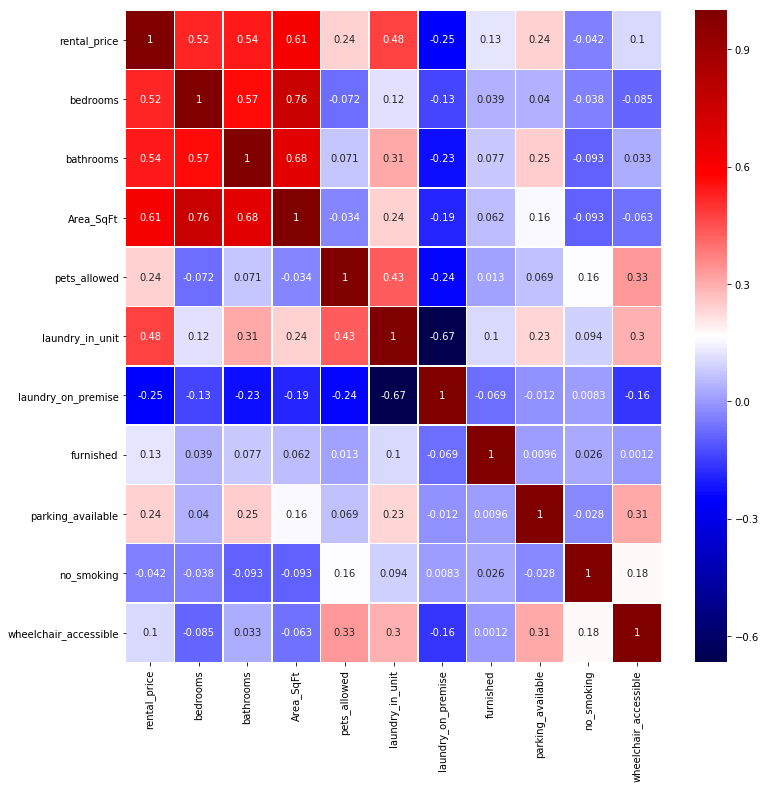

In [31]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(sfrent_df.corr(), cmap="seismic", annot=True, linewidths=.5, ax=ax);

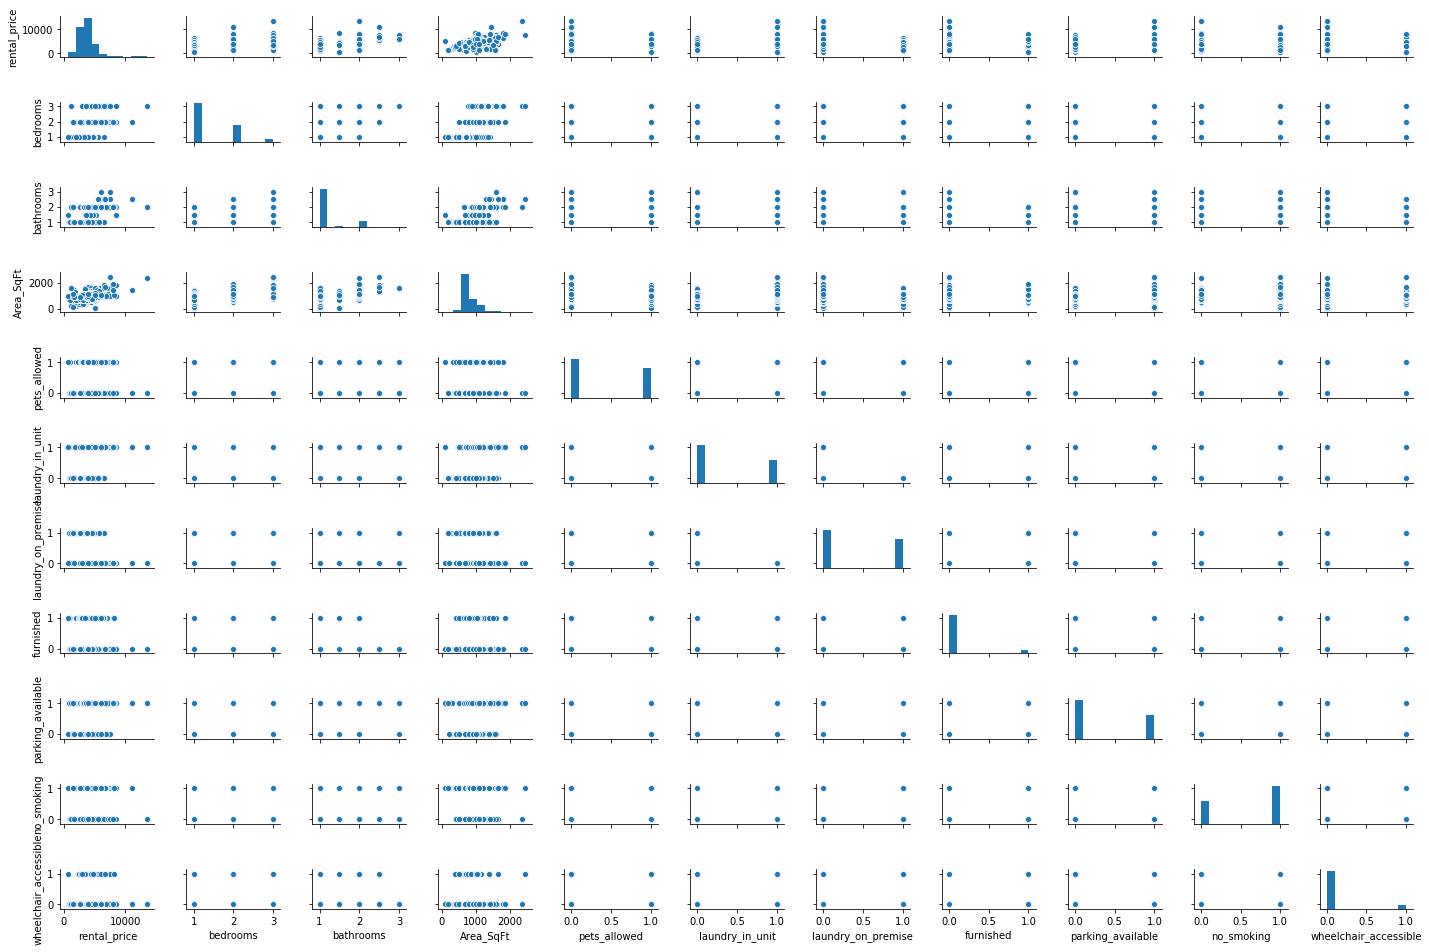

In [32]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(sfrent_df, height=1.2, aspect=1.5);



Nothing out of the ordinary from the below plots. The correlation between square footage and number of bedrooms and bathrooms are as expected

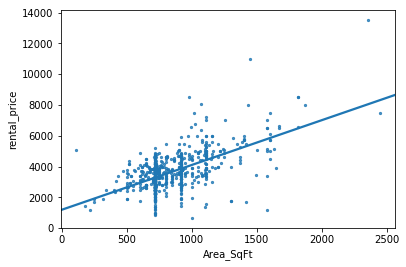

In [33]:
#PLOT of Area vs Rental Price
ax = sns.regplot(x='Area_SqFt', y='rental_price', data=sfrent_df, scatter_kws={"s": 5}, robust=True, ci=None)

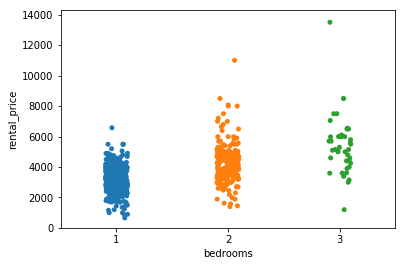

In [34]:
#PLOT of Bedrooms vs Rental Price
ax = sns.stripplot(x='bedrooms', y='rental_price', data=sfrent_df, jitter=True)

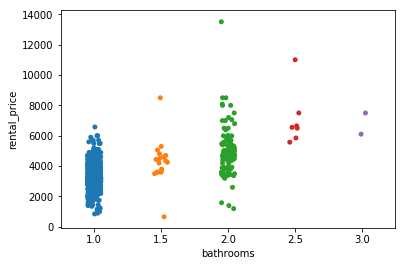

In [35]:
#PLOT of Bathroom vs Rental Price
ax = sns.stripplot(x='bathrooms', y='rental_price', data=sfrent_df, jitter=True)

In [36]:
# Sort correlation vs. price in descending order to gauge which features are more important
sfrent_df.corr()['rental_price'].sort_values(ascending=False)

rental_price             1.000000
Area_SqFt                0.610725
bathrooms                0.537987
bedrooms                 0.518368
laundry_in_unit          0.479112
parking_available        0.241528
pets_allowed             0.240749
furnished                0.125088
wheelchair_accessible    0.104575
no_smoking              -0.041661
laundry_on_premise      -0.253607
Name: rental_price, dtype: float64

In [37]:
# Create feature matrix (X) and target vector (y)
y, X = patsy.dmatrices("rental_price ~ bedrooms + bathrooms + Area_SqFt + pets_allowed + laundry_in_unit \
+ laundry_on_premise + furnished + parking_available + no_smoking \
+ wheelchair_accessible", data=sfrent_df, return_type="dataframe")

In [38]:
# Create model
model = sm.OLS(y, X)

# Fit model to training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rental_price   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     90.78
Date:                Thu, 23 May 2019   Prob (F-statistic):          3.98e-122
Time:                        20:40:33   Log-Likelihood:                -6204.9
No. Observations:                 763   AIC:                         1.243e+04
Df Residuals:                     752   BIC:                         1.248e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               762.5919    137.032      5.565      0.000     493.581    1031.603
bedrooms                422.5438     80.933      5.221      0.000     263.661     581.426
bathrooms               291.3692    112.006      2.601      0.009      71.488     511.251
Area_SqFt                 1.5576      0.214      7.282      0.000       1.138       1.977
pets_allowed            348.7244     70.413      4.953      0.000     210.495     486.954
laundry_in_unit         920.8457     97.351      9.459      0.000     729.733    1111.958
laundry_on_premise      333.3875     83.974      3.970      0.000     168.536     498.238
furnished               269.2337    107.633      2.501      0.013      57.937     480.531
parking_available       168.5025     69.968      2.408      0.016      31.148     305.857
no_smoking             -133.9319     64.542     -2.075      0.038    -260.635      -7.229
wheelchair_accessible   -20.6748    112.005     -0.185      0.854    -240.555     199.205
==============================================================================
Omnibus:                      186.527   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2603.101
Skew:                           0.685   Prob(JB):                         0.00
Kurtosis:                      11.945   Cond. No.                     4.42e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

-- 

Dropped "wheelchair_accesible" due to very high p-value, also from domain knowledge I know this is not very important for the majority of people looking to rent. Updated target and feature variables, however, the changes were insignificant.

In [39]:
# removed "wheelchair_accesible"
y, X = patsy.dmatrices('rental_price ~ bedrooms + bathrooms + Area_SqFt + pets_allowed + laundry_in_unit \
+ laundry_on_premise + furnished + parking_available + no_smoking' , data=sfrent_df, return_type="dataframe")

# Create model
model = sm.OLS(y, X)

# Fit model to training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rental_price   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     101.0
Date:                Thu, 23 May 2019   Prob (F-statistic):          3.92e-123
Time:                        20:40:38   Log-Likelihood:                -6204.9
No. Observations:                 763   AIC:                         1.243e+04
Df Residuals:                     753   BIC:                         1.248e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            761.6554    136.850      5.566      0.000     493.002    1030.309
bedrooms             422.5060     80.881      5.224      0.000     263.726     581.286
bathrooms            291.5222    111.931      2.604      0.009      71.788     511.256
Area_SqFt              1.5607      0.213      7.325      0.000       1.142       1.979
pets_allowed         345.8724     68.653      5.038      0.000     211.099     480.646
laundry_in_unit      919.2034     96.881      9.488      0.000     729.013    1109.393
laundry_on_premise   333.9599     83.863      3.982      0.000     169.327     498.592
furnished            269.5747    107.548      2.507      0.012      58.445     480.705
parking_available    164.7641     66.929      2.462      0.014      33.374     296.154
no_smoking          -135.5625     63.893     -2.122      0.034    -260.993     -10.132
==============================================================================
Omnibus:                      186.512   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2610.848
Skew:                           0.684   Prob(JB):                         0.00
Kurtosis:                      11.958   Cond. No.                     4.42e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


**NOTE:** 

The coefficient for the feature, "laundry_in_unit", appears to be irregularly high. At \\$919, it is higher than the intercept of \\$761. One possible explanation for this is that apartment and homes with washer/dryer within the dwelling unit tends to be much newer and in better living condition, as it would require additional plumbing, fixtures, and building code compliance. In other words, units with washer/dryer all happens to be in newer/remodeled/modern homes that commands higher rental prices. Therefore, the laundry_in_unit feature encapsulates other ammenities or benefits of the unit, that the other features in this study do not. Of course, this hyptothesis will require additional research and is out of the scope of this project. 

The coefficent for beadrooms (\\$423) and bathrooms (\\$292) appears a bit low based with respect to the some of the other features, and general domain knowledge of current SF rental prices. However, these ranges are reasonable given the R-squared score of .547 and relatively high mean-square error of $852.

---





The residual plot looks good as all of the data points appears random and looks evenly distributed across the 0 axis

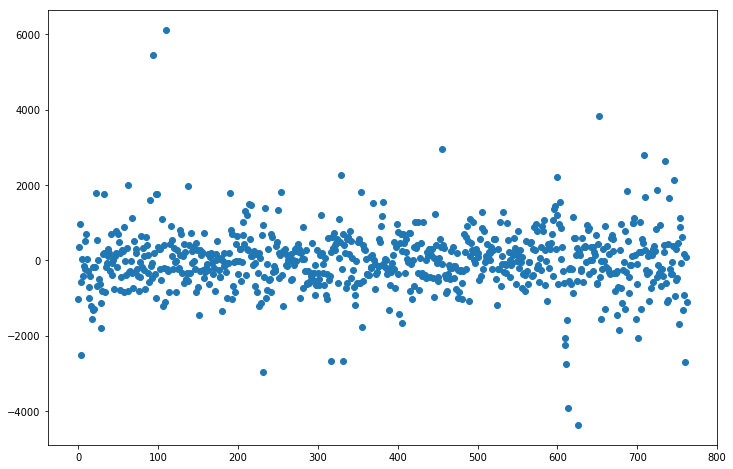

In [40]:
# Use statsmodels to plot the residuals
fit.resid.plot(style='o', figsize=(12,8));

---

TEST: Dropped two categorical factors (no smoking, furnished) I know are probably not very important. Dropping 'no smoking', 'furnished' did not change the model by too much, slightly lower R^2, lower kurtosis. Therefore, I am keeping these features. 

In [ ]:
# # y_test, X_test = patsy.dmatrices('rental_price ~ bedrooms + bathrooms + Area_SqFt + pets_allowed + laundry_in_unit \
# #  + laundry_on_premise + parking_available' , data=sfrent_df, return_type="dataframe")

# # Create model
# model_test = sm.OLS(y_test, X_test)

# # Fit model to training set
# fit_test = model_test.fit()

# # Print summary statistics of the model's performance
# fit_test.summary()

---

Using SKlearn to double check Stats Model results, R^2 score is identical

In [41]:
# Create an empty model
lr = LinearRegression()

y0, X0 = patsy.dmatrices('rental_price ~ bedrooms + bathrooms + Area_SqFt + pets_allowed + laundry_in_unit \
+ laundry_on_premise + furnished + parking_available + no_smoking' , data=sfrent_df, return_type="dataframe")

# Fit the model to the full dataset
lr.fit(X0, y0)

# Print out the R^2 for the model against the full dataset
lr.score(X0,y0)

0.5469245340111237

---

#### The below sections shows the modification of functional form of features. Log-scaling the target, and several features did not improve the model. 

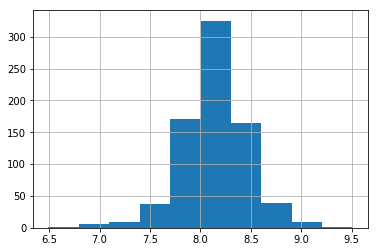

In [42]:
# take log of price and graph
sfrent_df['log_price']=np.log(sfrent_df.rental_price)
sfrent_df.log_price.hist();
#looks better than before

In [43]:
# using log_price did not improve the model
y, X = patsy.dmatrices('log_price ~ bedrooms + bathrooms + Area_SqFt + pets_allowed + laundry_in_unit \
+ laundry_on_premise + furnished + parking_available + no_smoking' , data=sfrent_df, return_type="dataframe")

model2 = sm.OLS(y, X)
fit2 = model2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     72.19
Date:                Thu, 23 May 2019   Prob (F-statistic):           1.19e-95
Time:                        20:41:31   Log-Likelihood:                -4.9448
No. Observations:                 763   AIC:                             29.89
Df Residuals:                     753   BIC:                             76.26
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.4694      0.040    184.513      0.000       7.390       7.549
bedrooms               0.1557      0.024      6.510      0.000       0.109       0.203
bathrooms              0.0362      0.033      1.092      0.275      -0.029       0.101
Area_SqFt              0.0003    6.3e-05      4.094      0.000       0.000       0.000
pets_allowed           0.1225      0.020      6.033      0.000       0.083       0.162
laundry_in_unit        0.2674      0.029      9.329      0.000       0.211       0.324
laundry_on_premise     0.1156      0.025      4.658      0.000       0.067       0.164
furnished              0.0429      0.032      1.349      0.178      -0.020       0.105
parking_available      0.0576      0.020      2.909      0.004       0.019       0.096
no_smoking            -0.0436      0.019     -2.309      0.021      -0.081      -0.007
==============================================================================
Omnibus:                      335.694   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3075.512
Skew:                          -1.744   Prob(JB):                         0.00
Kurtosis:                      12.197   Cond. No.                     4.42e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
sfrent_df.corr()['log_price'].sort_values(ascending=False)

log_price                1.000000
rental_price             0.947434
Area_SqFt                0.508566
bedrooms                 0.463450
laundry_in_unit          0.462243
bathrooms                0.451868
pets_allowed             0.280059
parking_available        0.239453
wheelchair_accessible    0.117140
furnished                0.091186
no_smoking              -0.029722
laundry_on_premise      -0.217721
Name: log_price, dtype: float64

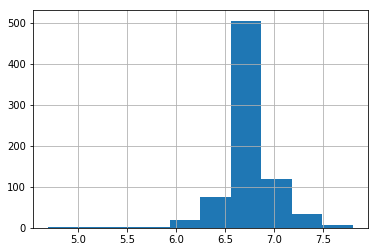

In [45]:
# take log of area and graph
sfrent_df['log_Area']=np.log(sfrent_df.Area_SqFt)
sfrent_df['log_bed']=np.log(sfrent_df.bedrooms)
sfrent_df['log_bath']=np.log(sfrent_df.bathrooms)
sfrent_df['log_Laundry']=np.log(sfrent_df.laundry_in_unit)
sfrent_df.log_Area.hist();

In [46]:
sfrent_df.corr()['rental_price'].sort_values(ascending=False)

rental_price             1.000000
log_price                0.947434
Area_SqFt                0.610725
log_Area                 0.548417
bathrooms                0.537987
log_bath                 0.532554
bedrooms                 0.518368
log_bed                  0.511432
laundry_in_unit          0.479112
parking_available        0.241528
pets_allowed             0.240749
furnished                0.125088
wheelchair_accessible    0.104575
no_smoking              -0.041661
laundry_on_premise      -0.253607
log_Laundry                   NaN
Name: rental_price, dtype: float64

**Note: Logging several features did not improve the model at all as you can see that the correlation coefficients are lower with the log price**

---
### Validating with SKLEARN: check functional forms, adjust polynomails, apply regularization


Performing a random train and test split at test_size = 0.3 yielded similar R^2 score as models above. Results: 0.601, 0.573, 0.492, .507, .565, .582  **Average ~ .553**

In [47]:
# Random train/test split
y, X = patsy.dmatrices('rental_price ~ bedrooms + bathrooms + Area_SqFt + pets_allowed + laundry_in_unit \
+ laundry_on_premise + furnished + parking_available + no_smoking' , data=sfrent_df, return_type="dataframe")

lr = LinearRegression()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Fit the model against the training data
lr.fit(X_train, y_train)

# Evaluate the model against the testing data
lr.score(X_test, y_test)

0.5361725259607466

---

Root Mean squared error from a 5-fold cross validation resulted in a average of about 852 dollars. This is reasonable given that the average rent is about 3638 dollars, and the adjusted R^2 score is .547 meaning this model explains just a little bit more than half of the variance. (see below section)

In [48]:
# 5-fold cross-validation 
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=5, scoring= 'neg_mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

# took squareroot of average of the scores to get RMSE 
err = np.sqrt(np.average(-scores))
print(err)

[1077625.18457098  438855.42699108  573702.31109718  438690.49267612
 1100238.0410958 ]
851.9520475274602


using sklearn.cross_validation Kfold method yielded a slightly lower R^2 score

In [49]:
est=LinearRegression()

kf=KFold(n_splits=5,shuffle=True, random_state =4)
# kf.get_n_splits(len(X))

all_scores=[] 

# get indices of corresponding train & test
for train,test in kf.split(X):
    x_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.02: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
np.mean(all_scores)

0.5288930702347073

---

Adjusting Polynomials did not improve the model

In [50]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)

In [51]:
cross_val_score(lr, X_poly, y, cv=5)

array([ 0.35995254,  0.22044706, -0.0011058 ,  0.25273778,  0.20085531])

Applying Ridge Cross Validation did not imporved the model

In [52]:
scaler = StandardScaler() # standardize data pior to applying regularization
X_std = scaler.fit_transform(X)

X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size=0.3)

In [53]:
# ridgeCV uses cross-validation to find alpha and then runs a normal regression for the score
rcv = RidgeCV(cv=5)
rcv.fit(X_train_std, y_train)
rcv.score(X_test_std, y_test)

0.5452752830424782

Applying Lasso Cross Validation did not improved the model, in fact it made the model worse by more than 0.1  (See Below)

In [60]:
scaler = StandardScaler() # standardize data pior to applying regularization
X_std = scaler.fit_transform(X)

In [61]:
from sklearn.linear_model import LassoCV

model = LassoCV()
fitted = model.fit(X_std, y)
print(fitted.score)
# print(dir(model))

<bound method RegressorMixin.score of LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)>


In [62]:
from sklearn.model_selection import GridSearchCV

model = Lasso()
# param_grid = {'alpha': [0, 1e-1, 1, 100, 1000, 10000]} 
# applied different ranges of alpha to dial in on optimal number
param_grid = {'alpha': [0,1,2,3,4,5,6,7,8,9,10]}
# param_grid = {'alpha': [0,10,20,30,40,50,60,70,80,90,100]}
grid = GridSearchCV(model, param_grid=param_grid)
grid.fit(X_std, y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [63]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 5}
0.4161563773197266


Applying regularization with polynomials degree 2 made the model worse as well

In [64]:
scaler = StandardScaler() # standardize data pior to applying regularization
X_poly2 = scaler.fit_transform(X_poly)

In [65]:
# model = LassoCV()
# model.fit(X_poly2, y)

model = Ridge()
# param_grid = {'alpha': [0, 1e-1, 1, 100, 1000, 10000, 1000000]}
param_grid = {'alpha': np.linspace(10,100,100)}
# param_grid = {}
grid = GridSearchCV(model, param_grid=param_grid)
grid.fit(X_poly2, y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([ 10.     ,  10.90909, ...,  99.09091, 100.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [66]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 100.0}
0.4241681386683621


In [67]:
model = Lasso()
# param_grid = {'alpha': [0, 1e-1, 1, 100, 1000, 10000, 1000000]}
param_grid = {'alpha': np.linspace(10,100,100)}
# param_grid = {}
grid = GridSearchCV(model, param_grid=param_grid)
grid.fit(X_poly2, y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([ 10.     ,  10.90909, ...,  99.09091, 100.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [68]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 14.545454545454545}
0.43136291462571047


Given that both Ridge and Lasso Cross Validations made the model worse by a fairly large amount, it is safe to say that regularization will not improve the model, and therefore will not be applied.

Additional Check to see verify that higher degrees polynomial will not help the model 

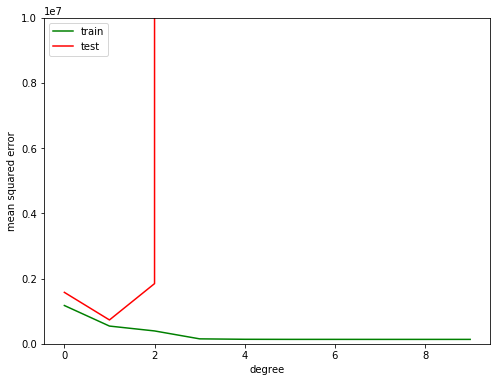

In [69]:
# create polynomial features by taking our individual features and raising them 
# to a chosen power (range 0-9 degrees) 

# import Standard Scaler and input into pipeline to standardize features
# scales our data down to a range between 0 and 1
from sklearn.preprocessing import StandardScaler

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=10)

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

# Step through degrees from 0 to 9 and store the training and test (generalization) error.
# create array of zeros,
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(StandardScaler(),PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim((0.0, 1e7))
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')

There was an unexpected spike in MSE on the training curve when the polynomial was at degree 2 when the test_size was at .8 and random state = 8.  When the random state was changed OR the test_size was changed, the training curve showed a normal curve such as the one above. However this didn't matter too much since the train and test errors was lowest at degree 1. A degree two or higher would lead to overfitting.

---
After determining that regularization, modifying polynomials, and function forms does not improve the model, I decided to remove some features. Re-running and testing below.

In [70]:
y2, X2 = patsy.dmatrices('rental_price ~ Area_SqFt + pets_allowed + laundry_in_unit \
+ laundry_on_premise + furnished + parking_available' , data=sfrent_df, return_type="dataframe")

# Create model
model2 = sm.OLS(y2, X2)

# Fit model to training set
fit2 = model2.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rental_price   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     136.9
Date:                Thu, 23 May 2019   Prob (F-statistic):          3.34e-117
Time:                        20:50:52   Log-Likelihood:                -6226.3
No. Observations:                 763   AIC:                         1.247e+04
Df Residuals:                     756   BIC:                         1.250e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            734.2482    128.492      5.714      0.000     482.005     986.491
Area_SqFt              2.6539      0.131     20.313      0.000       2.397       2.910
pets_allowed         329.1171     69.824      4.714      0.000     192.045     466.189
laundry_in_unit      873.5448     98.168      8.898      0.000     680.830    1066.260
laundry_on_premise   282.3169     85.475      3.303      0.001     114.521     450.113
furnished            270.0335    110.268      2.449      0.015      53.565     486.502
parking_available    168.6923     67.127      2.513      0.012      36.915     300.470
==============================================================================
Omnibus:                      139.523   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1793.076
Skew:                           0.384   Prob(JB):                         0.00
Kurtosis:                      10.471   Cond. No.                     4.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
# Random train/test split
y2, X2 = patsy.dmatrices('rental_price ~ Area_SqFt + pets_allowed + laundry_in_unit \
+ laundry_on_premise + furnished + parking_available' , data=sfrent_df, return_type="dataframe")

lr2 = LinearRegression()
# INSTRUCTOR NOTE: Run this multiple times to show the variation
# Split the data into training and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3)
# Fit the model against the training data
lr2.fit(X2_train, y2_train)
# Evaluate the model against the testing data
lr2.score(X2_test, y2_test)

# Results: 0.606, .341, .444, .561, .37, .464
# Average ~ .465

0.4317927923574696

In [72]:
# 5-fold cross-validation 
reg2 = LinearRegression()
scores2 = cross_val_score(reg2, X2, y2, cv=5, scoring='neg_mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores2)

# took squareroot of average of the scores 
err2 = np.sqrt(np.average(-scores2))
print(err2)
# error = 922 (dollars)

[1094784.57114627  506353.38167578  624136.52065357  462381.13504099
 1142757.75447494]
875.2614881270102


---
After trying several iterations of different combinations of features being removed, some combinations did show slight improvements in skew, kurtosis, condition number, however, the improvements did not justify the large decrease in R-squared scroe and higher mean square error. 

In conclusion, the original ordinary least squares method provided the best prediction model. Adding regularization, modifying polynomials, and modifying function forms would only lead to overfitting, a significant drop in R-squared score, and lower the prediction accuracy of the model. 

 ---
 Recommendations for Rentees:
 1. Use Area (square footage) as a proxy for price. Area has the highest correlation with price, and the number of bedroom and bathrooms have a high colinearity with area. 
 2. Look for units with laundry on premise instead of laundry in unit. Rentals with washer and dryers within the unit commands a premium in prices.
 3. Look for places that do not allow pets if you don’t have any. Pets allowed is a factor that tend to increase rent prices moderately.

  
    
    

Future Improvements to this Model:
1. Add more data by scraping other websites such as Zillow and Trulia 
2. Add location (zip code) as categorical features 
3. Add time-series analysis to determine if rental units with similar features shows any variance in prices throughout the year
4. Use current and future data as a basis in a seperate prediction model on determing tenant buyout agreements base on above mentioned features and location factors.
